# Logistic Regression on Campaigns

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymysql as sql
%matplotlib inline
import seaborn as sns; sns.set()
import math

from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import itertools

import statsmodels.api as sm

# output multiple lines per block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
# read in the data
host="bootcamp-open.ctzjfvqmre0y.us-east-1.rds.amazonaws.com"
port=3306
dbname="team_2"
user="team_2"
password="captechlistens!"

conn = sql.connect(host, user=user,port=port, passwd=password, db=dbname)

In [4]:
client = pd.read_sql('SELECT * FROM team_2.client', con=conn)
prev_campaign = pd.read_sql('SELECT * FROM team_2.prev_campaign', con=conn)

In [5]:
current_campaign = pd.read_csv('C:/Users/bdickie/Downloads/current_campaign-822.csv')
campaigns_all = pd.read_excel('C:/Users/bdickie/Downloads/all.xlsx')
contacted_raw = pd.read_excel('C:/Users/bdickie/Downloads/contacted.xlsx')

# Preliminary Visualization of Response

In [14]:
sql = "SELECT * \
  FROM client \
  LEFT JOIN prev_campaign ON team_2.client.id = team_2.prev_campaign.ClientID"
data = pd.read_sql(sql, con=conn)
contacted = data[data.DaysPassed != -1]
contacted.describe()

,Age,balance,CarLoan,ID,DefaultFlag,HHInsurance,ID,ClientID,DaysPassed,PrevAttempts,success,failure
count,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000,5134.000000
mean,41.411180,1822.844674,0.175302,47353.522400,0.211141,0.590767,20601.945267,47353.522400,216.218543,3.757304,0.237047,0.762953
std,11.301622,3132.074296,0.380262,19692.952261,0.408158,0.491740,6100.551413,19692.952261,112.122933,2.549323,0.425313,0.425313
min,18.000000,-8355.000000,0.000000,10002.000000,0.000000,0.000000,10001.000000,10002.000000,1.000000,1.000000,0.000000,0.000000
25%,33.000000,154.000000,0.000000,50292.000000,0.000000,0.000000,15267.500000,50292.000000,129.000000,2.000000,0.000000,1.000000
50%,41.000000,1660.832159,0.000000,55520.000000,0.000000,1.000000,20610.500000,55520.000000,206.000000,3.000000,0.000000,1.000000
75%,49.000000,3373.000000,0.000000,60691.750000,0.000000,1.000000,25896.750000,60691.750000,292.750000,5.000000,0.000000,1.000000
max,92.000000,52587.000000,1.000000,66119.000000,1.000000,1.000000,31117.000000,66119.000000,854.000000,58.000000,1.000000,1.000000


In [16]:
contacted.Outcome.unique()

array(['success', 'failure', 'other', ''], dtype=object)

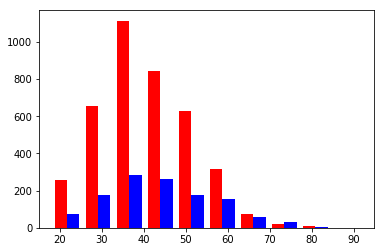

In [30]:
# plot response by age
plt.hist(
    [contacted[contacted['success'] == 0]['Age'].values, 
     contacted[contacted['success'] == 1]['Age'].values],
     color=['r', 'b']);

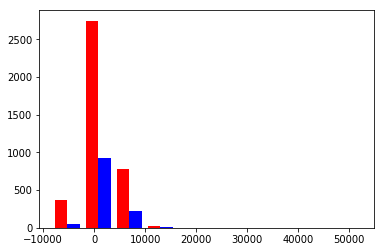

In [31]:
# plot response by balance
plt.hist(
    [contacted[contacted['success'] == 0]['balance'].values, 
     contacted[contacted['success'] == 1]['balance'].values],
     color=['r', 'b']);

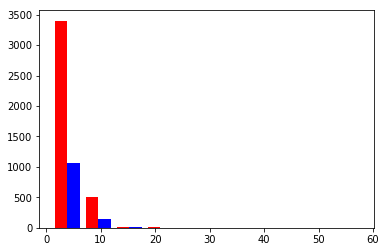

In [32]:
# plot response by previous attempts
plt.hist(
    [contacted[contacted['success'] == 0]['PrevAttempts'].values, 
     contacted[contacted['success'] == 1]['PrevAttempts'].values],
     color=['r', 'b']);

# Data Cleaning (sclient)

Get response variable (Car Insurance) into data frame

In [6]:
# get response variable into data frame
bought = campaigns_all.groupby('ClientID').sum().loc[:, ['Car Insurance']]
bought.loc[bought['Car Insurance'] > 1, 'Car Insurance'] = 1
bought.describe()

,Car Insurance
count,21122.000000
mean,0.453177
std,0.497815
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
## sclient = client + success column
sclient = pd.merge(client, bought, how='left', left_on='ID', right_on='ClientID')
sclient = sclient.drop('ID', axis=1)
sclient.head()

,Age,balance,CarLoan,DefaultFlag,Education,Gender,HHInsurance,Job,Marital,Car Insurance
0,32,1218.0,0,0,tertiary,F,1,management,single,1
1,32,1156.0,0,0,primary,F,1,blue-collar,married,0
2,29,637.0,0,0,tertiary,F,1,management,single,1
3,25,373.0,0,0,primary,F,1,student,single,0
4,30,2694.0,0,0,tertiary,F,0,management,married,0


<br>
<br>
Deal with missing values

In [8]:
# set "" = "N/A"
sclient = sclient.replace("", "N/A")
sclient.isnull().sum()

Age              0
balance          0
CarLoan          0
DefaultFlag      0
Education        0
Gender           0
HHInsurance      0
Job              0
Marital          0
Car Insurance    0
dtype: int64

In [9]:
sclient.Education.describe() # mode is secondary
sclient.Job.describe() # mode is management

count         21122
unique            4
top       secondary
freq          10678
Name: Education, dtype: object

count          21122
unique            12
top       management
freq            4864
Name: Job, dtype: object

<br>
<br>
Remove numeric outliers

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


98417.0

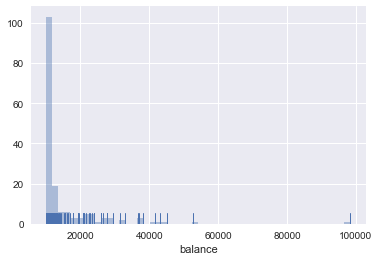

In [10]:
# explore outliers in balance
high_balance = sclient.loc[sclient['balance'] > 10000, 'balance']
sns.distplot(high_balance, kde = False, rug = True);
high_balance.max() # one account at nearly $1million.... let's drop this outlier

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


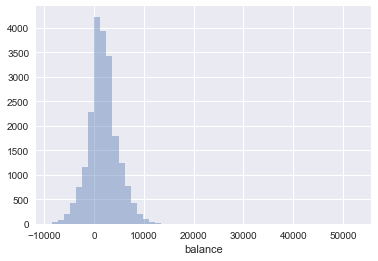

In [11]:
sclient = sclient[sclient.balance != high_balance.max()]
sclient = sclient.reset_index(drop=True)
sns.distplot(sclient.balance, kde = False);

<br>
<br>
Change data types

In [12]:
sclient.dtypes

Age                int64
balance          float64
CarLoan            int64
DefaultFlag        int64
Education         object
Gender            object
HHInsurance        int64
Job               object
Marital           object
Car Insurance      int64
dtype: object

In [13]:
# change 0,1s to booleans
sclient['CarLoan'] = sclient['CarLoan'].astype('bool')
sclient['DefaultFlag'] = sclient['DefaultFlag'].astype('bool')
sclient['HHInsurance'] = sclient['HHInsurance'].astype('bool')
sclient['Car Insurance'] = sclient['Car Insurance'].astype('bool')

In [14]:
# change objects to factors
sclient['Education'] = sclient['Education'].astype('category')
sclient['Gender'] = sclient['Gender'].astype('category')
sclient['Job'] = sclient['Job'].astype('category')
sclient['Marital'] = sclient['Marital'].astype('category')

In [15]:
sclient.dtypes

Age                 int64
balance           float64
CarLoan              bool
DefaultFlag          bool
Education        category
Gender           category
HHInsurance          bool
Job              category
Marital          category
Car Insurance        bool
dtype: object

<br>
<br>
Standardize numeric values

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


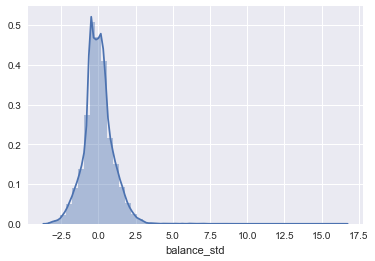

In [16]:
# standardize balance
sclient['balance_std'] = (sclient.balance - sclient.balance.mean())/sclient.balance.std()
sclient = sclient.drop('balance', axis=1)
sns.distplot(sclient.balance_std);

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


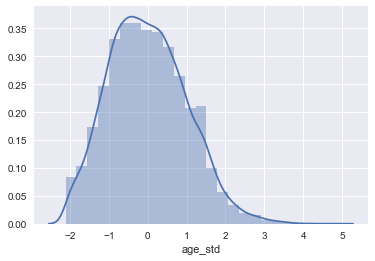

In [17]:
# standardize age
sclient['age_std'] = (sclient.Age - sclient.Age.mean())/sclient.Age.std()
sclient = sclient.drop('Age', axis=1)
sns.distplot(sclient.age_std, bins = 25);

# Data Cleaning (contacted)

In [18]:
contacted = contacted_raw.drop(['CampaignID', 'ClientID', 'DaysPassed.1', 'Call_Start', 'Last_Contact'], axis=1)
contacted.head()

,success,Current_Campaign,DaysPassed,Duration,Hour,No_Of_Contacts,Weekday,Age,balance,CarLoan,DefaultFlag,Education,Gender,HHInsurance,Job,Marital
0,0,1,36,18.0,14.0,3,Thursday,56,-2220.0,0,1,primary,M,1,retired,married
1,0,1,206,85.0,9.0,2,Tuesday,59,2605.0,0,0,secondary,F,1,blue-collar,married
2,0,1,73,223.0,14.0,1,Tuesday,49,518.0,0,0,primary,F,1,blue-collar,married
3,1,1,26,614.0,14.0,4,Sunday,55,1392.0,0,0,tertiary,F,0,self-employed,single
4,0,0,138,NaN,NaN,2,NaN,55,1392.0,0,0,tertiary,F,0,self-employed,single


<br>
<br>
Deal with missing values

In [19]:
# set NaN (in categorical variables) = "N/A"
contacted.loc[:,['Education', 'Job']] = contacted.replace(np.nan, "N/A")
contacted.isnull().sum()

success                0
Current_Campaign       0
DaysPassed             0
Duration            5134
Hour                5134
No_Of_Contacts         0
Weekday             5134
Age                    0
balance                0
CarLoan                0
DefaultFlag            0
Education              0
Gender                 0
HHInsurance            0
Job                    0
Marital                0
dtype: int64

<br>
<br>
Change data types

In [20]:
contacted.dtypes

success               int64
Current_Campaign      int64
DaysPassed            int64
Duration            float64
Hour                float64
No_Of_Contacts        int64
Weekday              object
Age                   int64
balance             float64
CarLoan               int64
DefaultFlag           int64
Education            object
Gender               object
HHInsurance           int64
Job                  object
Marital              object
dtype: object

In [21]:
# change 0,1s to booleans
contacted['success'] = contacted['success'].astype('bool')
contacted['Current_Campaign'] = contacted['Current_Campaign'].astype('bool')
contacted['CarLoan'] = contacted['CarLoan'].astype('bool')
contacted['DefaultFlag'] = contacted['DefaultFlag'].astype('bool')
contacted['HHInsurance'] = contacted['HHInsurance'].astype('bool')

In [22]:
# change objects to factors
contacted['Hour'] = contacted['Hour'].astype('category')
contacted['Weekday'] = contacted['Weekday'].astype('category')
contacted['Education'] = contacted['Education'].astype('category')
contacted['Gender'] = contacted['Gender'].astype('category')
contacted['Job'] = contacted['Job'].astype('category')
contacted['Marital'] = contacted['Marital'].astype('category')

In [23]:
contacted.dtypes

success                 bool
Current_Campaign        bool
DaysPassed             int64
Duration             float64
Hour                category
No_Of_Contacts         int64
Weekday             category
Age                    int64
balance              float64
CarLoan                 bool
DefaultFlag             bool
Education           category
Gender              category
HHInsurance             bool
Job                 category
Marital             category
dtype: object

<br>
<br>
Standardize numeric values

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


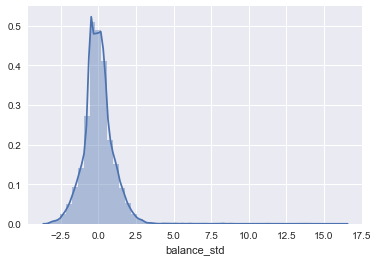

In [24]:
# standardize balance
contacted = contacted[contacted.balance != high_balance.max()]
contacted = contacted.reset_index(drop=True)
contacted['balance_std'] = (contacted.balance - contacted.balance.mean())/contacted.balance.std()
contacted = contacted.drop('balance', axis=1)
sns.distplot(contacted.balance_std);

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


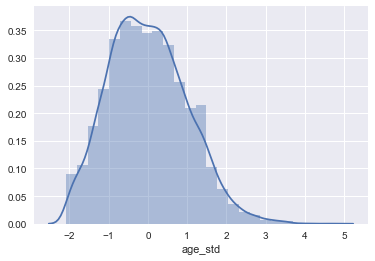

In [25]:
# standardize age
contacted['age_std'] = (contacted.Age - contacted.Age.mean())/contacted.Age.std()
contacted = contacted.drop('Age', axis=1)
sns.distplot(contacted.age_std, bins = 25);

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


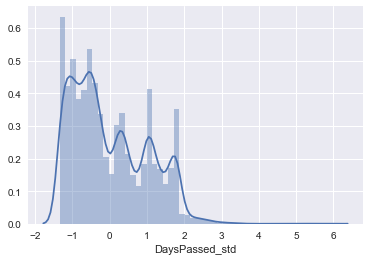

In [26]:
# standardize DaysPassed
contacted['DaysPassed_std'] = (contacted.DaysPassed - contacted.DaysPassed.mean())/contacted.DaysPassed.std()
contacted = contacted.drop('DaysPassed', axis=1)
sns.distplot(contacted['DaysPassed_std']);

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


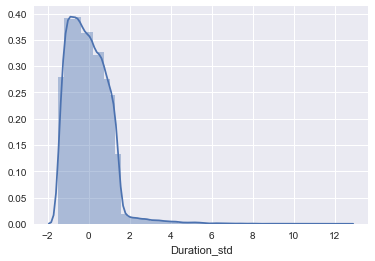

In [27]:
# standardize Duration
contacted['Duration_std'] = (contacted.Duration - np.nanmean(contacted.Duration))/np.nanstd(contacted.Duration)
contacted = contacted.drop('Duration', axis=1)
sns.distplot(contacted['Duration_std'].dropna());

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


58

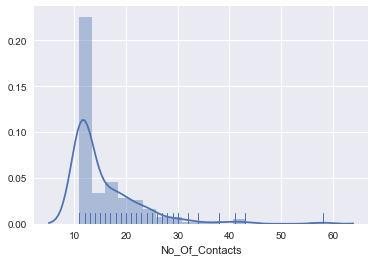

In [28]:
sns.distplot(contacted.loc[contacted['No_Of_Contacts'] > 10, 'No_Of_Contacts'], rug = True)
contacted.No_Of_Contacts.max() # remove this outlier
contacted = contacted[contacted.No_Of_Contacts != contacted.No_Of_Contacts.max()]

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


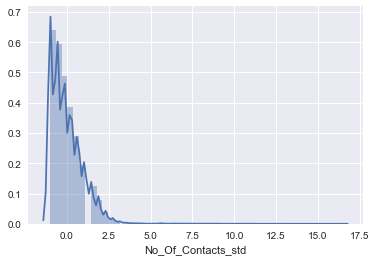

In [29]:
# standardize No_Of_Contacts
contacted['No_Of_Contacts_std'] = (contacted.No_Of_Contacts - contacted.No_Of_Contacts.mean())/contacted.No_Of_Contacts.std()
contacted = contacted.drop('No_Of_Contacts', axis=1)
sns.distplot(contacted['No_Of_Contacts_std']);

CONTACTED1

In [30]:
contacted1 = contacted[contacted.Current_Campaign == 1].drop('Current_Campaign', axis=1)
contacted1 = contacted1.reset_index(drop = True)
contacted1.head()

,success,Hour,Weekday,CarLoan,DefaultFlag,Education,Gender,HHInsurance,Job,Marital,balance_std,age_std,DaysPassed_std,Duration_std,No_Of_Contacts_std
0,False,14.0,Thursday,False,True,primary,M,True,retired,married,-1.295551,1.308131,-1.040666,-1.422905,-0.175514
1,False,9.0,Tuesday,False,False,secondary,F,True,blue-collar,married,0.247985,1.576360,0.410618,-1.135693,-0.589154
2,False,14.0,Tuesday,False,False,primary,F,True,blue-collar,married,-0.419654,0.682263,-0.724799,-0.544124,-1.002793
3,True,14.0,Sunday,False,False,tertiary,F,False,self-employed,single,-0.140058,1.218721,-1.126036,1.131990,0.238125
4,True,12.0,Tuesday,False,False,tertiary,F,False,technician,married,-1.047392,-0.033015,-0.426005,0.497553,-1.002793


# Data Visualization

SCLIENT

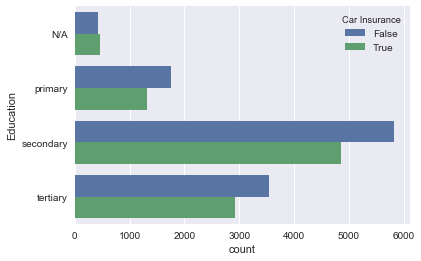

In [618]:
sns.countplot(y='Education', hue = 'Car Insurance', data = sclient);
    # people that did not report education are most likely to buy car insurance

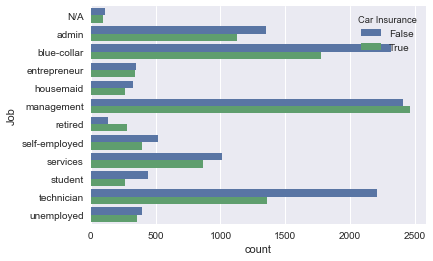

In [619]:
sns.countplot(y='Job', hue = 'Car Insurance', data = sclient);
    # management, retired are highly likely
    # technicians, blue-collar are unlikely

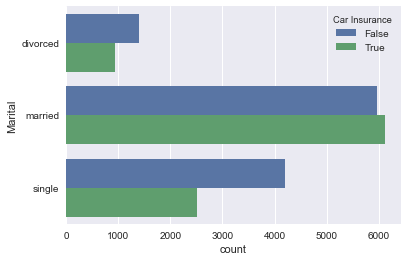

In [620]:
sns.countplot(y='Marital', hue = 'Car Insurance', data = sclient);
    # Married people more likely to buy car insurance

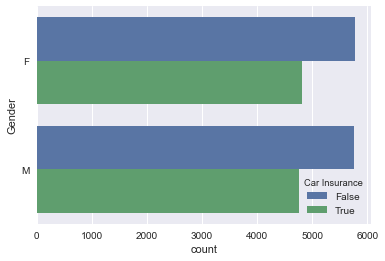

In [621]:
sns.countplot(y='Gender', hue='Car Insurance', data = sclient);
    # no difference in gender

In [622]:
#sclient_bools = sclient.select_dtypes(include=['bool'])
#sclient_bools.head()
#for i in range(len(sclient_bools)):
#    var = sclient_bools.columns[i]
#    if var != 'Car Insurance':
#        sns.countplot(x=var, hue='Car Insurance', data = sclient);

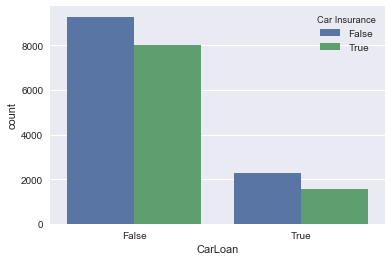

In [623]:
sns.countplot(x='CarLoan', hue='Car Insurance', data = sclient); # no difference

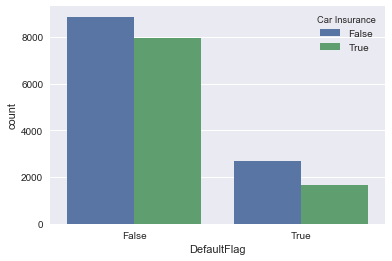

In [624]:
sns.countplot(x="DefaultFlag", hue='Car Insurance', data = sclient); # no difference

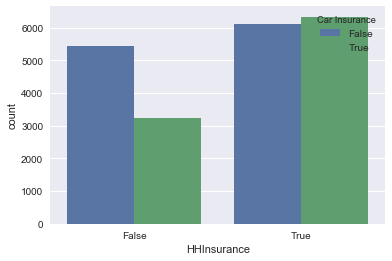

In [625]:
sns.countplot(x='HHInsurance', hue='Car Insurance', data = sclient); # more likely if they have homeowners 

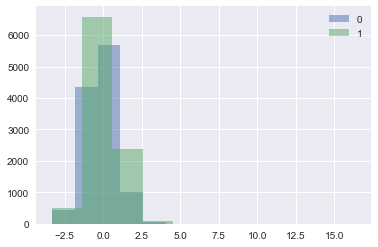

In [626]:
# balance (std)
for value in [0,1]:
    plot_df = sclient[sclient['Car Insurance'] == value];
    plt.hist(plot_df.balance_std, alpha = 0.5); 
plt.legend([0,1], loc='upper right'); 

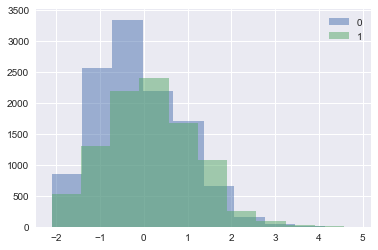

In [627]:
# age (std)
for value in [0,1]:
    plot_df = sclient[sclient['Car Insurance'] == value];
    plt.hist(plot_df.age_std, alpha = 0.5); 
plt.legend([0,1], loc='upper right'); # younger people are less likely to buy

CONTACTED

In [628]:
contacted1_raw = contacted_raw[contacted_raw.Current_Campaign == 1].drop('Current_Campaign', axis=1)
contacted1_raw.head()

,CampaignID,success,ClientID,DaysPassed,Duration,Call_Start,Hour,DaysPassed.1,Last_Contact,No_Of_Contacts,Weekday,Age,balance,CarLoan,DefaultFlag,Education,Gender,HHInsurance,Job,Marital
0,110000,0,50758,36,18.0,14:20:54,14.0,36,2018-07-19,3,Thursday,56,-2220.000000,0,1,primary,M,1,retired,married
1,110001,0,10641,206,85.0,9:06:44,9.0,206,2018-01-30,2,Tuesday,59,2605.000000,0,0,secondary,F,1,blue-collar,married
2,110003,0,11686,73,223.0,14:44:10,14.0,73,2018-06-12,1,Tuesday,49,518.000000,0,0,primary,F,1,blue-collar,married
3,110004,1,51250,26,614.0,14:04:31,14.0,26,2018-07-29,4,Sunday,55,1392.000000,0,0,tertiary,F,0,self-employed,single
5,110005,1,62342,108,466.0,12:17:56,12.0,108,2018-05-08,1,Tuesday,41,-1444.268903,0,0,tertiary,F,0,technician,married


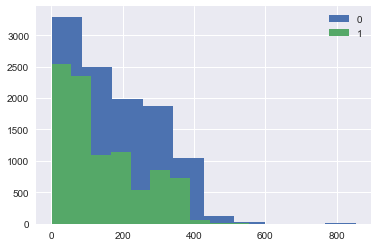

In [629]:
for value in [0,1]:
    plot_df = contacted_raw[contacted_raw['success'] == value];
    plt.hist(plot_df.DaysPassed); 
plt.legend([0,1], loc='upper right'); 
# no difference in distributions

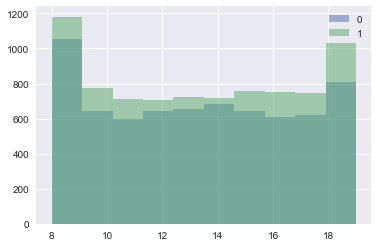

In [630]:
for value in [0,1]:
    plot_df = contacted1_raw[contacted1_raw['success'] == value];
    plt.hist(plot_df.Hour, alpha=0.5); # no difference
plt.legend([0,1], loc='upper right'); 

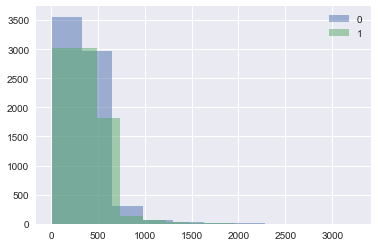

In [631]:
for value in [0,1]:
    plot_df = contacted1_raw[contacted1_raw['success'] == value];
    plt.hist(plot_df.Duration, alpha=0.5);
plt.legend([0,1], loc='upper right'); 

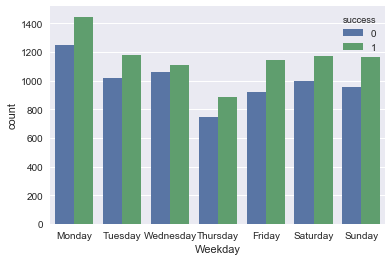

In [632]:
sns.countplot(x='Weekday', hue = 'success', data = contacted1_raw,
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']); 
    # Wednesday performs slightly worse

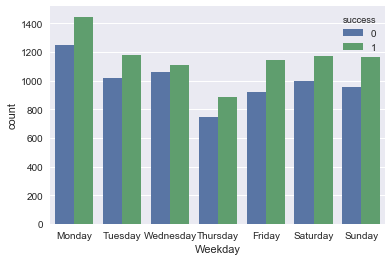

In [633]:
sns.countplot(x='Weekday', hue = 'success', data = contacted1_raw,
             order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']); 

# Model 1: What clients are likely to have auto insurance with the client?

For this analysis, we will be using sclient - the client database concatenated with the success column from all campaigns.

Check assumptions for a logistic regression: <br>
1) Response variable (Car Insurance) is binary <br>
2) Predictor variables are independent <br>
3) Numerical predictor variables are linearly related to log(Odds(Car Insurance)) <br>
4) Large sample size <br>

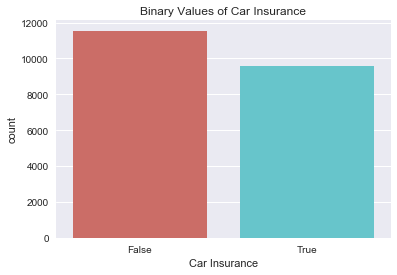

In [31]:
# Assumption 1
sns.countplot(x='Car Insurance', data=sclient, palette='hls');
plt.title("Binary Values of Car Insurance");

              CarLoan  DefaultFlag  HHInsurance  balance_std   age_std
CarLoan      1.000000     0.148110    -0.103721    -0.107403 -0.136139
DefaultFlag  0.148110     1.000000    -0.151935    -0.203359 -0.078003
HHInsurance -0.103721    -0.151935     1.000000     0.084048  0.131519
balance_std -0.107403    -0.203359     0.084048     1.000000  0.108195
age_std     -0.136139    -0.078003     0.131519     0.108195  1.000000


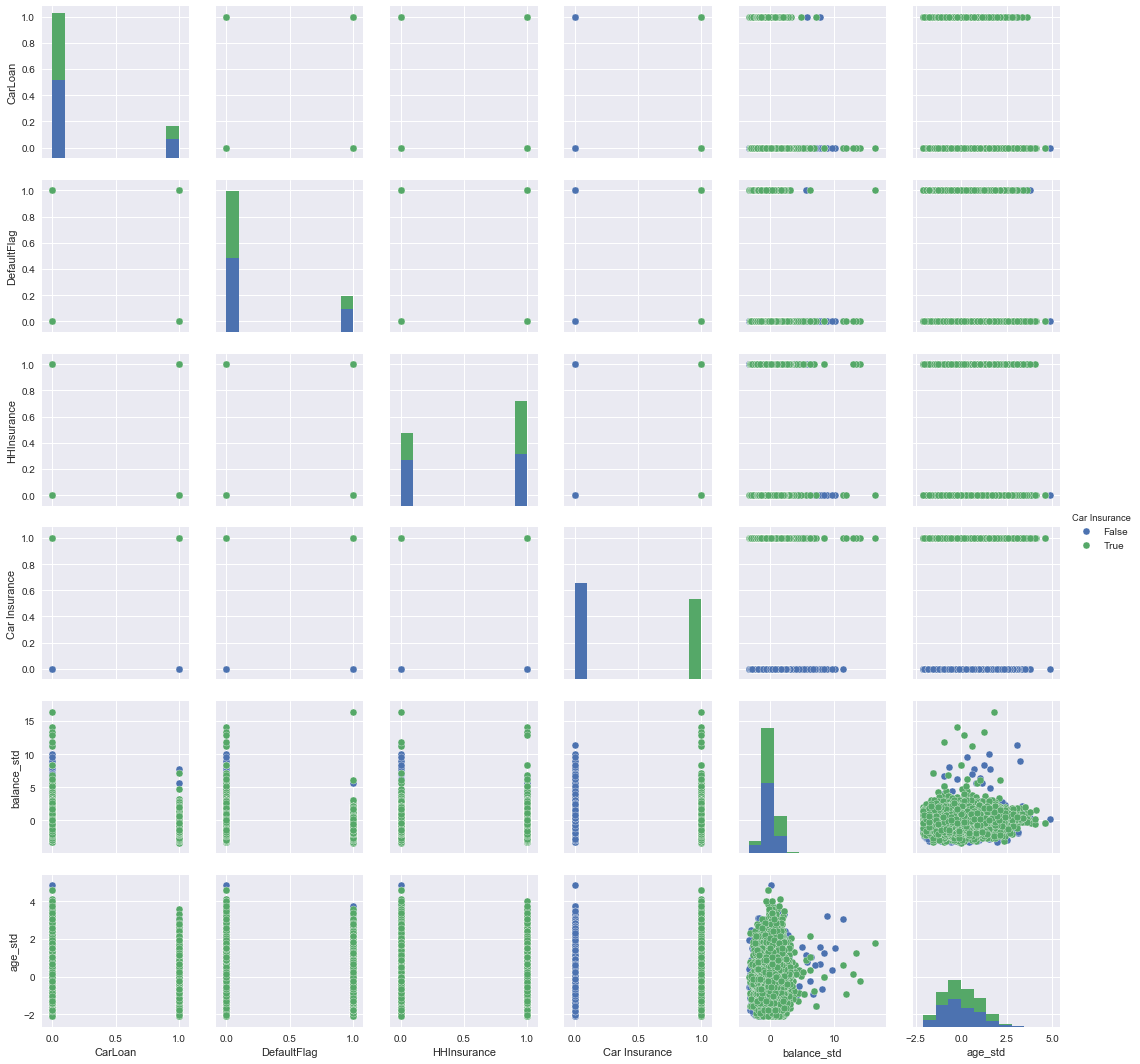

In [635]:
# Assumption 2
sns.pairplot(sclient, hue = 'Car Insurance');
print(sclient.drop('Car Insurance', axis = 1).corr())

In [636]:
# Assumption 3
def calc_odds_A(x_prop):
    p = x_prop[1] / (x_prop[0] + x_prop[1])
    odds = p / (1 - p)
    return odds

def calc_odds_notA(x_prop):
    p = x_prop[0] / (x_prop[0] + x_prop[1])
    odds = p / (1 - p)
    return odds

In [637]:
odds_A = calc_odds_A(sclient.groupby('Car Insurance').CarLoan.count())
odds_notA = calc_odds_notA(sclient.groupby('Car Insurance').CarLoan.count())

print(odds_A, odds_notA)

0.8288163477357345 1.20653990806519


In [638]:
# Assumption 4
sclient.count()

CarLoan          21121
DefaultFlag      21121
Education        21121
Gender           21121
HHInsurance      21121
Job              21121
Marital          21121
Car Insurance    21121
balance_std      21121
age_std          21121
dtype: int64

In order to consider categorical variables, they must be coded into "dummy variables", which have only two values: 0, 1 <br>
This allows us to regard the dummy variables as numerical so then can be used in our regression model.

The categorical variables in sclient: education, job, marital, gender

In [32]:
cat_vars = ['Job', 'Gender']
refactor = ['Education', 'Marital']

df = sclient

# dummy variables
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    df=data1

# Education
length = np.arange(0, df.Education.count())
edu = pd.DataFrame(index=length, 
                   columns=['Education_reported', 'Education_notReported'], 
                   dtype='uint8')
for row in length:
    if df.iloc[row, 2] == 'N/A':
        edu.iloc[row, 0] = 0 
        edu.iloc[row, 1] = 1
    else:
        edu.iloc[row, 0] = 1 
        edu.iloc[row, 1] = 0
edu = edu.astype('uint8')
data1=df.join(edu)
df=data1

# Marital
length = np.arange(0, df.Education.count())
marry = pd.DataFrame(index=length, 
                     columns=['Marital_married', 'Marital_notMarried'], 
                     dtype='uint8')
for row in length:
    if df.iloc[row, 6] == 'married':
        marry.iloc[row, 0] = 1 
        marry.iloc[row, 1] = 0
    else:
        marry.iloc[row, 0] = 0 
        marry.iloc[row, 1] = 1
marry = marry.astype('uint8')
data1=df.join(marry)
df=data1


base_cases = ['Job_unemployed', 'Gender_M', 'Education_notReported',  'Marital_notMarried']
cat_vars = cat_vars + refactor
to_drop = cat_vars + base_cases
sclient_vars = df.columns.values.tolist()
to_keep = [i for i in sclient_vars if i not in to_drop]
sclient_final = df[to_keep]

sclient_final.columns

Index(['CarLoan', 'DefaultFlag', 'HHInsurance', 'Car Insurance', 'balance_std',
       'age_std', 'Job_N/A', 'Job_admin', 'Job_blue-collar',
       'Job_entrepreneur', 'Job_housemaid', 'Job_management', 'Job_retired',
       'Job_self-employed', 'Job_services', 'Job_student', 'Job_technician',
       'Gender_F', 'Education_reported', 'Marital_married'],
      dtype='object')

Base Cases: <br>
    &nbsp;&nbsp;&nbsp;Education: notReported <br>
    &nbsp;&nbsp;&nbsp;Job: unemployed <br>
    &nbsp;&nbsp;&nbsp;Marital: notMarried <br>
    &nbsp;&nbsp;&nbsp;Gender: M

We now have all our variables correctly refactored. Set Car Insurance as the response variable (y) and all other variables as the features (X). Then, split the data into testing and training sets.

In [33]:
y = sclient_final['Car Insurance']
X = sclient_final.drop(['Car Insurance'], axis=1)

Feature Elimination

In [34]:
# drop gender
X = X.drop('Gender_F', axis = 1)
# drop Car Loan
X = X.drop('CarLoan', axis = 1)
# drop DefaultFlag
X = X.drop('DefaultFlag', axis = 1)

In [35]:
# split into sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Implementing the Model: y ~ X

In [36]:
model1 = LogisticRegression()
model1.fit(X_train, y_train);

model1_sm = sm.Logit(y_train, X_train.astype('float'))
result = model1_sm.fit()
print(result.summary())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimization terminated successfully.
         Current function value: 0.656665
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          Car Insurance   No. Observations:                14784
Model:                          Logit   Df Residuals:                    14768
Method:                           MLE   Df Model:                           15
Date:                Tue, 28 Aug 2018   Pseudo R-squ.:                 0.04617
Time:                        15:09:11   Log-Likelihood:                -9708.1
converged:                       True   LL-Null:                       -10178.
                                        LLR p-value:                1.079e-190
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
HHInsurance            0.4821      0.035     13.818      0.000       0.414       0.550
balan

Evaluate accuracy of the model on the test sets.

In [37]:
y_pred = model1.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(model1.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.598


In [38]:
y_pred_perc = model1.predict_proba(X_test)
y_pred_perc = pd.DataFrame(y_pred_perc)
threshold = 0.60
threshold_pred = []
for i in y_pred_perc.index:
    if y_pred_perc.iloc[i,1] > threshold:
        threshold_pred = threshold_pred + [True] 
    else:
        threshold_pred = threshold_pred + [False]

In [39]:
# prediction by percentage threshold
pred = pd.DataFrame(index=np.arange(0,len(y_test)), columns=['model_pred', 'threshold_pred', 'actual'])
pred.model_pred = y_pred
pred.threshold_pred = threshold_pred
pred.actual = y_test.reset_index(drop = True)
pred.head()

,model_pred,threshold_pred,actual
0,True,True,True
1,False,False,False
2,True,False,True
3,True,False,True
4,True,False,True


Confusion matrix, without normalization
[[2483  958]
 [1592 1304]]
Confusion matrix, without normalization
[[3138  303]
 [2416  480]]


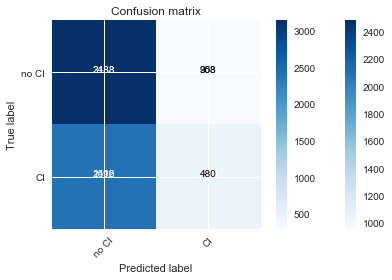

In [40]:
# confusion matrix

#total = cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]
#cm_perc = [[cm[0,0]/total*100, cm[0,1]/total*100], [cm[1,0]/total*100, cm[1,1]/total*100]]
#print(cm_perc)

cm_model = confusion_matrix(pred.actual, pred.model_pred)
plot_confusion_matrix(cm_model, ['no CI', 'CI'])

cm_threshold = confusion_matrix(pred.actual, pred.threshold_pred)
plot_confusion_matrix(cm_threshold, ['no CI', 'CI'])

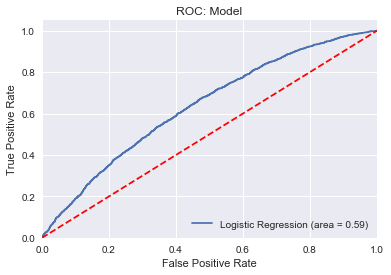

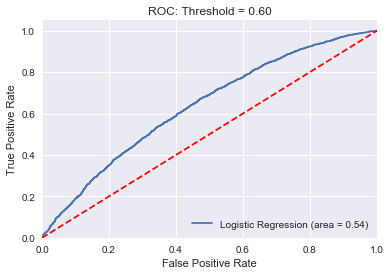

In [41]:
# ROC curve
logit_roc_auc = roc_auc_score(pred.actual, pred.model_pred);
fpr, tpr, thresholds = roc_curve(y_test, model1.predict_proba(X_test)[:,1]);
plt.figure();
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc);
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC: Model');
plt.legend(loc="lower right");
plt.show();

logit_roc_auc = roc_auc_score(pred.actual, pred.threshold_pred);
fpr, tpr, thresholds = roc_curve(y_test, model1.predict_proba(X_test)[:,1]);
plt.figure();
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc);
plt.plot([0, 1], [0, 1],'r--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC: Threshold = %0.2f' % threshold);
plt.legend(loc="lower right");
plt.show();

# Model 2 - What clients are likely to respond positively to the current campaign?

For this analysis, we will be using contacted1 - informaton from the current campaign database concatenated with the client data.

Check assumptions for a logistic regression: <br>
1) Response variable (success) is binary <br>
2) Predictor variables are independent <br>
3) Numerical predictor variables are linearly related to log(Odds(success)) <br>
4) Large sample size <br>

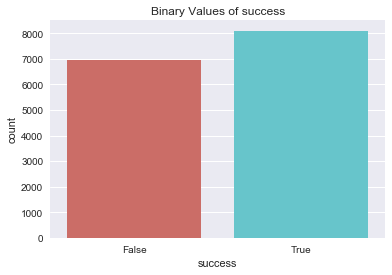

In [647]:
# Assumption 1
sns.countplot(x='success', data=contacted1, palette='hls');
plt.title("Binary Values of success");

                     CarLoan  DefaultFlag  HHInsurance  balance_std   age_std  \
CarLoan             1.000000     0.152205    -0.109791    -0.101624 -0.138803   
DefaultFlag         0.152205     1.000000    -0.153508    -0.196978 -0.080939   
HHInsurance        -0.109791    -0.153508     1.000000     0.086263  0.133613   
balance_std        -0.101624    -0.196978     0.086263     1.000000  0.111195   
age_std            -0.138803    -0.080939     0.133613     0.111195  1.000000   
DaysPassed_std     -0.029247     0.010781    -0.035201     0.018827  0.014814   
Duration_std       -0.001598     0.007489     0.000812     0.010395  0.007521   
No_Of_Contacts_std  0.005587     0.032364     0.006524    -0.020150  0.013553   

                    DaysPassed_std  Duration_std  No_Of_Contacts_std  
CarLoan                  -0.029247     -0.001598            0.005587  
DefaultFlag               0.010781      0.007489            0.032364  
HHInsurance              -0.035201      0.000812         

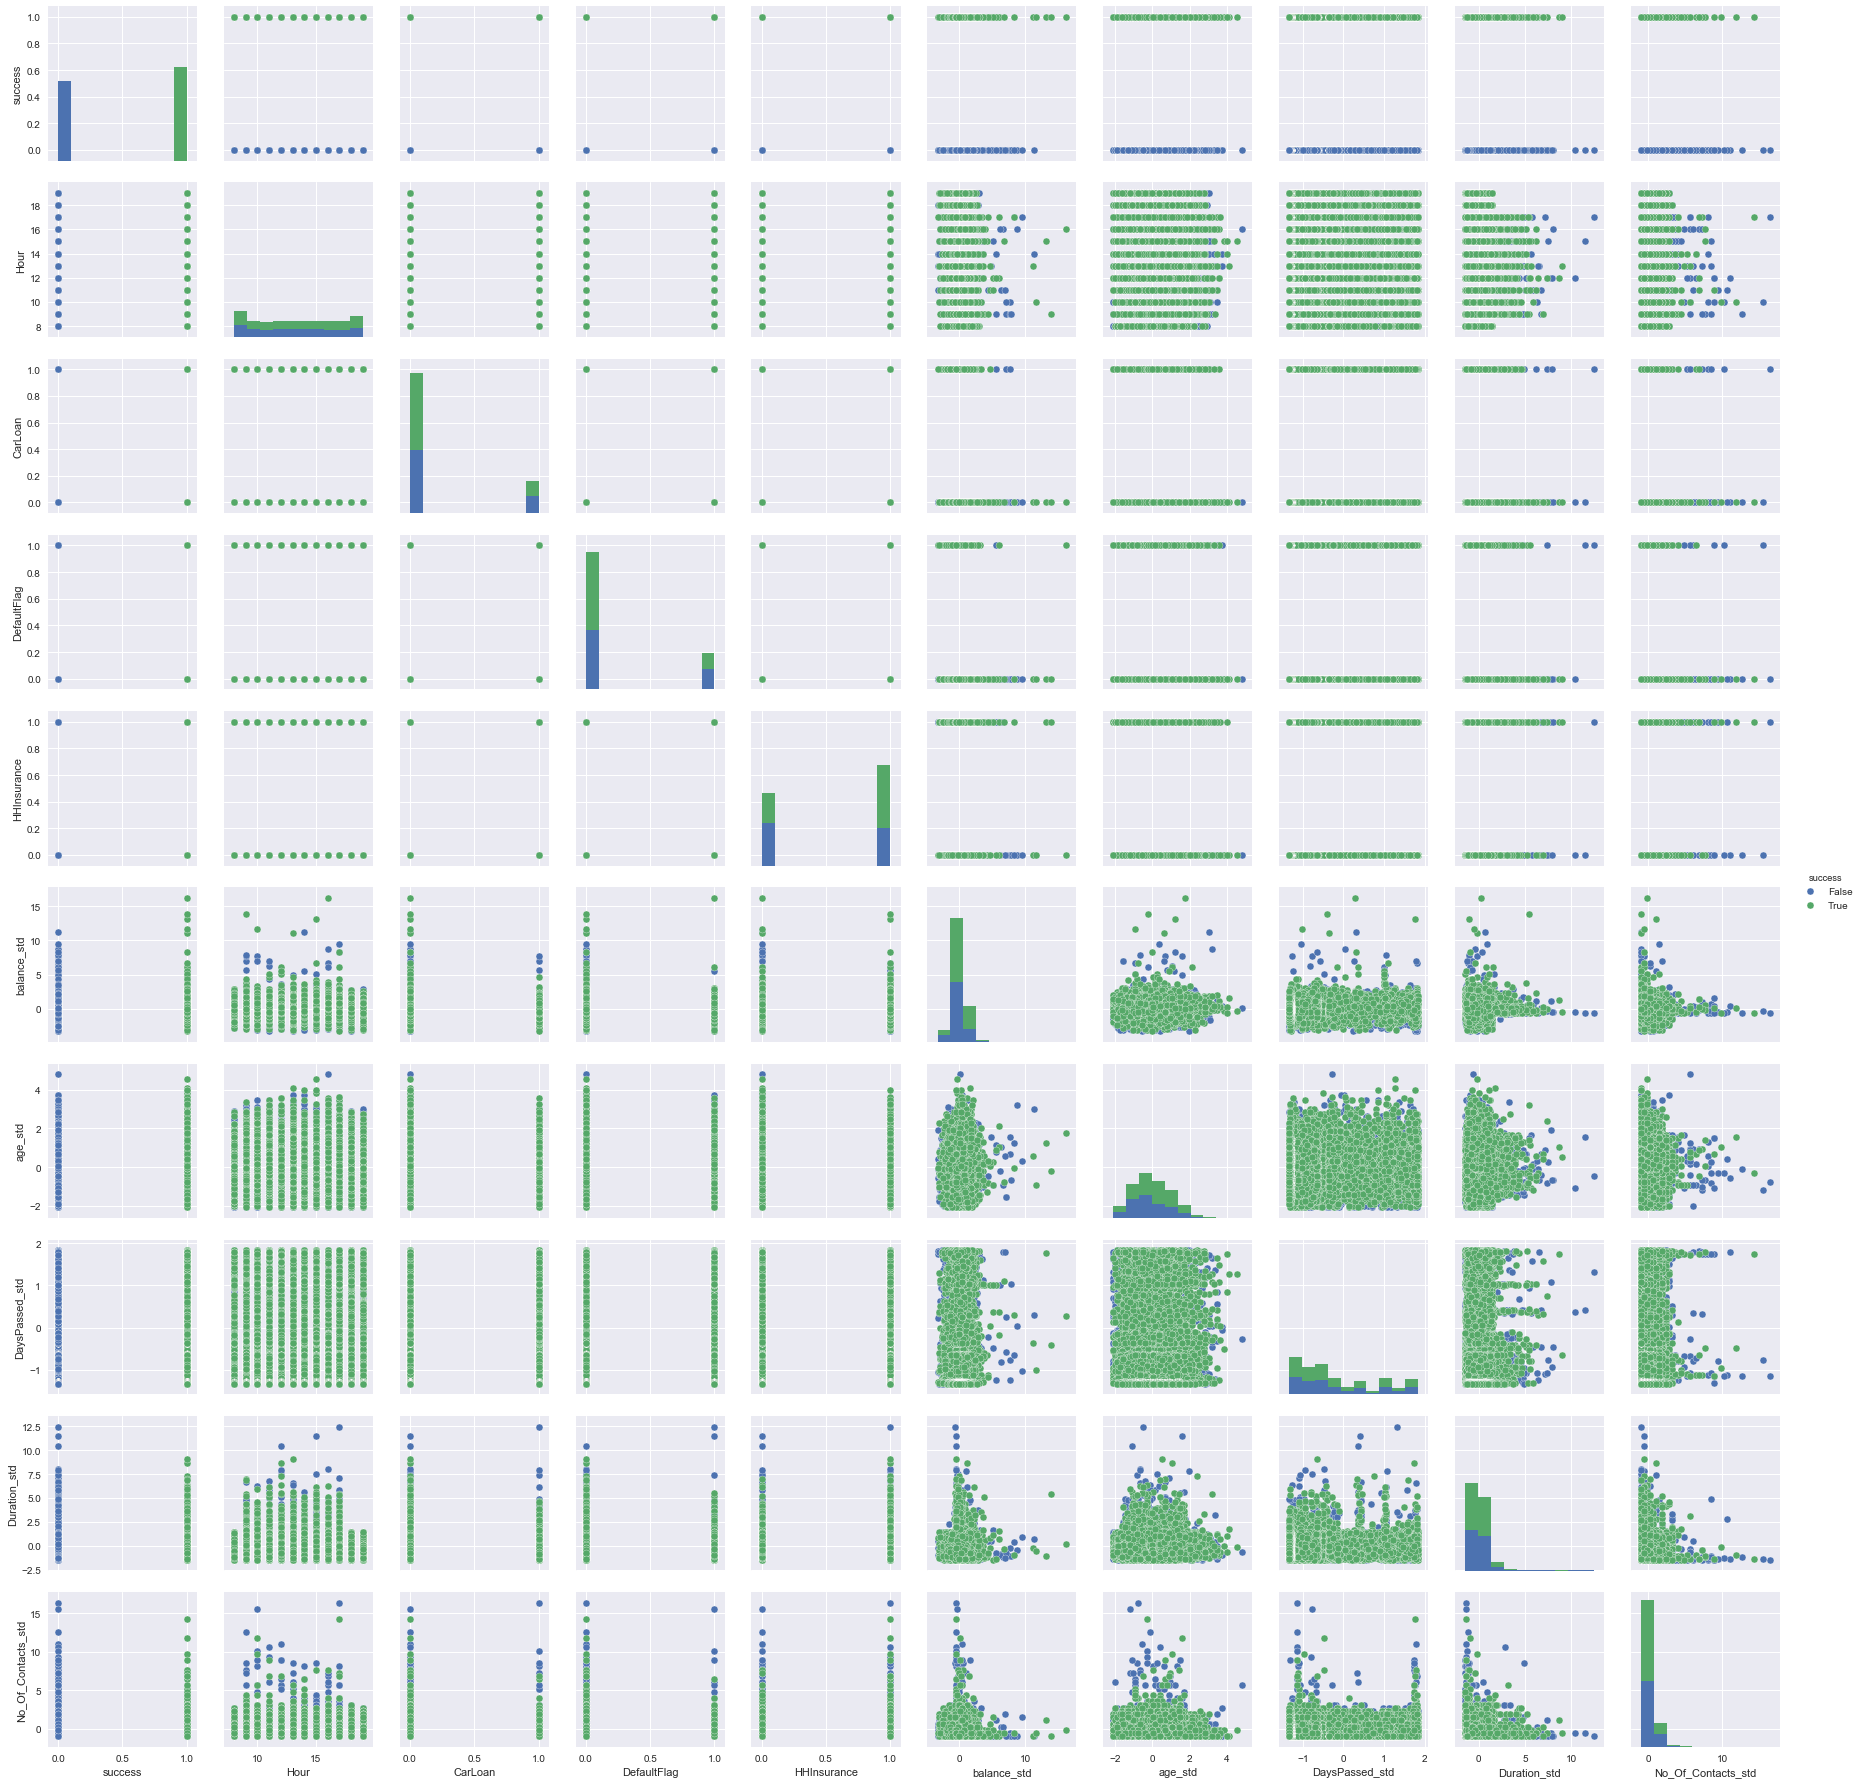

In [648]:
# Assumption 2
sns.pairplot(contacted1, hue = 'success');
print(contacted1.drop('success', axis = 1).corr())

In [649]:
# Assumption 3

In [650]:
# Assumption 4
contacted1.count()

success               15050
Hour                  15050
Weekday               15050
CarLoan               15050
DefaultFlag           15050
Education             15050
Gender                15050
HHInsurance           15050
Job                   15050
Marital               15050
balance_std           15050
age_std               15050
DaysPassed_std        15050
Duration_std          15050
No_Of_Contacts_std    15050
dtype: int64

In order to consider categorical variables, they must be coded into "dummy variables", which have only two values: 0, 1 <br>
This allows us to regard the dummy variables as numerical so then can be used in our regression model.

The categorical variables in contacted1: Hour, Weekday, Education, Job, Marital, Gender

In [63]:
cat_vars = ['Hour', 'Weekday', 'Job', 'Gender', 'Education', 'Marital']

df = contacted1

# dummy variables
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(df[var], prefix=var)
    data1=df.join(cat_list)
    df=data1
    
# Education
# length = np.arange(0, df.Education.count())
# edu = pd.DataFrame(index=length, 
#                    columns=['Education_reported', 'Education_notReported'], 
#                    dtype='uint8')
# for row in length:
#     if df.iloc[row, 2] == 'N/A':
#         edu.iloc[row, 0] = 0 
#         edu.iloc[row, 1] = 1
#     else:
#         edu.iloc[row, 0] = 1 
#         edu.iloc[row, 1] = 0
# edu = edu.astype('uint8')
# data1=df.join(edu)
# df=data1

# Marital
# length = np.arange(0, df.Education.count())
# marry = pd.DataFrame(index=length, 
#                      columns=['Marital_married', 'Marital_notMarried'], 
#                      dtype='uint8')
# for row in length:
#     if df.iloc[row, 6] == 'married':
#         marry.iloc[row, 0] = 1 
#         marry.iloc[row, 1] = 0
#     else:
#         marry.iloc[row, 0] = 0 
#         marry.iloc[row, 1] = 1
# marry = marry.astype('uint8')
# data1=df.join(marry)
# df=data1

base_cases = ['Hour_12.0', 'Weekday_Monday', 
              'Job_unemployed', 'Gender_M', 
              'Education_primary', 'Marital_single']
              #'Education_notReported', 'Marital_notMarried']
#cat_vars = cat_vars + refactor
to_drop = cat_vars + base_cases
contacted1_vars = df.columns.values.tolist()
to_keep = [i for i in contacted1_vars if i not in to_drop]
contacted1_final = df[to_keep]

contacted1_final.columns

Index(['success', 'CarLoan', 'DefaultFlag', 'HHInsurance', 'balance_std',
       'age_std', 'DaysPassed_std', 'Duration_std', 'No_Of_Contacts_std',
       'Hour_8.0', 'Hour_9.0', 'Hour_10.0', 'Hour_11.0', 'Hour_13.0',
       'Hour_14.0', 'Hour_15.0', 'Hour_16.0', 'Hour_17.0', 'Hour_18.0',
       'Hour_19.0', 'Weekday_Friday', 'Weekday_Saturday', 'Weekday_Sunday',
       'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday', 'Job_N/A',
       'Job_admin', 'Job_blue-collar', 'Job_entrepreneur', 'Job_housemaid',
       'Job_management', 'Job_retired', 'Job_self-employed', 'Job_services',
       'Job_student', 'Job_technician', 'Gender_F', 'Education_N/A',
       'Education_secondary', 'Education_tertiary', 'Marital_divorced',
       'Marital_married'],
      dtype='object')

Base Cases: <br>
    &nbsp;&nbsp;&nbsp;Hour: noon <br>
    &nbsp;&nbsp;&nbsp;Weekday: Wednesday <br>
    &nbsp;&nbsp;&nbsp;Education: not reported <br>
    &nbsp;&nbsp;&nbsp;Job: unemployed <br>
    &nbsp;&nbsp;&nbsp;Marital: not married <br>
    &nbsp;&nbsp;&nbsp;Gender: M

We now have all our variables correctly refactored. Set success as the response variable (y) and all other variables as the features (X). Then, split the data into testing and training sets.

In [66]:
y = contacted1_final['success']
X = contacted1_final.drop(['success'], axis=1)

Feature Selection

In [94]:
# ranking 
logreg = LogisticRegression()
rfe = RFE(logreg, 1)
rfe = rfe.fit(X, y)
print(rfe.support_)
print(rfe.ranking_)

ranked = pd.DataFrame(index=np.arange(0, len(X.columns)), columns=['vars', 'ranking'])
ranked.vars = X.columns
ranked.ranking = rfe.ranking_

ranked.sort_values('ranking')

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False]
[33  8  2  7 13 40 31 15 29 21 28 32 22 18 38 24 30 17 11 25 39 35 34 42
 19 27 23 14 10 37  9  1 36 20  6  4 41  5 12 16 26  3]


,vars,ranking
31,Job_retired,1
2,HHInsurance,2
41,Marital_married,3
35,Job_technician,4
37,Education_N/A,5
34,Job_student,6
3,balance_std,7
1,DefaultFlag,8
30,Job_management,9
28,Job_entrepreneur,10


In [58]:
bool_vars = X.select_dtypes(include=['bool', 'uint8'])
bool_vars = bool_vars.astype('bool')

logreg = LogisticRegression()
rfe = RFE(logreg, 1)
rfe = rfe.fit(bool_vars, y)
print(rfe.support_)
print(rfe.ranking_)

bool_toKeep = pd.DataFrame(index=np.arange(0, len(bool_vars.columns)), columns=['vars', 'ranking'])
bool_toKeep.vars = bool_vars.columns
bool_toKeep.ranking = rfe.ranking_
bool_toKeep = bool_toKeep[bool_toKeep['ranking'] == 1]

numerical_vars = X.select_dtypes(exclude=['bool', 'uint8']).columns
X_new = X[bool_toKeep.vars].join(X[numerical_vars])
X = X_new
X.head()

[False False False False False False  True False False False False False]
[ 7  2 10 12  9  8  1  6  4  5 11  3]


,Job_retired,balance_std,age_std,DaysPassed_std,Duration_std,No_Of_Contacts_std
0,1,-1.295551,1.308131,-1.040666,-1.422905,-0.175514
1,0,0.247985,1.576360,0.410618,-1.135693,-0.589154
2,0,-0.419654,0.682263,-0.724799,-0.544124,-1.002793
3,0,-0.140058,1.218721,-1.126036,1.131990,0.238125
4,0,-1.047392,-0.033015,-0.426005,0.497553,-1.002793


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Implementing the Model: y ~ X

In [68]:
model2 = LogisticRegression()
model2.fit(X_train, y_train);

model2_sm = sm.Logit(y_train, X_train.astype('float'))
result = model2_sm.fit()
print(result.summary())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Optimization terminated successfully.
         Current function value: 0.633136
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                10535
Model:                          Logit   Df Residuals:                    10493
Method:                           MLE   Df Model:                           41
Date:                Tue, 28 Aug 2018   Pseudo R-squ.:                 0.08253
Time:                        15:14:24   Log-Likelihood:                -6670.1
converged:                       True   LL-Null:                       -7270.1
                                        LLR p-value:                7.321e-225
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
CarLoan                -0.0463      0.054     -0.851      0.395      -0.153       0.060
De

In [95]:
# add coefficients to ranked
coeffs = pd.DataFrame(index=np.arange(len(X.columns)), columns = ['vars', 'coeffs'])
coeffs.vars = X.columns
coeffs.coeffs = model2.coef_.reshape(42,1)

coeffs.dtypes
ranked = pd.merge(ranked, coeffs, how="inner", on="vars")
ranked.sort_values('ranking')


vars       object
coeffs    float64
dtype: object

,vars,ranking,coeffs
31,Job_retired,1,0.284984
2,HHInsurance,2,0.748569
41,Marital_married,3,0.613019
35,Job_technician,4,-0.479847
37,Education_N/A,5,0.622415
34,Job_student,6,-0.242717
3,balance_std,7,0.246666
1,DefaultFlag,8,-0.275245
30,Job_management,9,0.233894
28,Job_entrepreneur,10,0.269942


Evaluate accuracy of the model on the test sets

In [96]:
y_pred = model2.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(model2.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.632


In [104]:
model2.predict_proba(X_test)
max(model2.predict_proba(X_test).reshape(9030,1))

array([[0.32759834, 0.67240166],
       [0.56419877, 0.43580123],
       [0.51782429, 0.48217571],
       ...,
       [0.70136198, 0.29863802],
       [0.43124271, 0.56875729],
       [0.81375014, 0.18624986]])

array([0.97214699])

Confusion matrix, without normalization
[[1123  968]
 [ 693 1731]]
[[24.87264673311185, 21.439645625692137], [15.348837209302326, 38.33887043189369]]


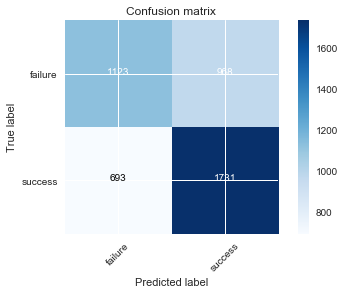

In [98]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
total = cm[0,0] + cm[0,1] + cm[1,0] + cm[1,1]
cm_perc = [[cm[0,0]/total*100, cm[0,1]/total*100], [cm[1,0]/total*100, cm[1,1]/total*100]]

plot_confusion_matrix(cm, ['failure', 'success'])
print(cm_perc)